## Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn 

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
import seaborn as sns 
from sklearn.metrics import accuracy_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

## Khám phá dữ liệu

In [2]:
data_df = pd.read_csv('Data/Data.csv',index_col = 'ID') # Cho cột index là cột 0 
data_df.head()

,State Name,State Abbreviation,Wind Direction,Created,Applicable Date,Min Temp,Max Temp,The Temp,Wind Speed,Air Pressure,Humidity,Visibility,Predictability
ID,,,,,,,,,,,,,
4581443174924288,Heavy Cloud,hc,102.747804,2016-01-28T15:50:47.001230Z,2016-01-28,24.7025,34.0925,33.79,8.587820,1013.0,59.0,11.895841,71
6336625583849472,Heavy Cloud,hc,91.709815,2016-01-28T12:50:47.353250Z,2016-01-28,24.9525,34.0725,33.79,8.470320,1013.0,59.0,11.895841,71
4559383551803392,Heavy Cloud,hc,91.709815,2016-01-28T09:50:46.720960Z,2016-01-28,24.9525,34.0725,33.79,8.470320,1013.0,59.0,11.895841,71
4623773701505024,Light Cloud,lc,95.785326,2016-01-28T06:50:47.016290Z,2016-01-28,24.9225,35.4250,33.86,9.630337,1013.0,57.0,11.991221,70
5238239505940480,Light Cloud,lc,95.785326,2016-01-28T03:51:02.272730Z,2016-01-28,24.9225,35.4250,33.86,9.630337,1013.0,57.0,11.991221,70


### Dữ liệu có bao nhiêu dòng và bao nhiêu cột?

In [3]:
# Kích thước của dữ liệu
data_df.shape

(71475, 13)

### Mỗi dòng có ý nghĩa gì? Có vấn đề các dòng có ý nghĩa khác nhau không?

Quan sát bộ dữ liệu ta thấy mỗi dòng chứa thông tin thời tiết của mỗi ngày

### Dữ liệu có các dòng bị lặp không?

In [4]:
# Kiểm tra dữ liệu thu thập được có bị trùng không
data_df.index.duplicated().sum()

0

### Mỗi cột có ý nghĩa gì?

Xem file "description.txt"

In [5]:
with open('description.txt', 'r',encoding = 'utf-8') as f:
    print(f.read())

***** DESCRIPTION WEATHER *****
Vị trí: Hồ Chí Minh City
Thời tiết 4 năm (2016,2017,2018,2019)
Predictability:
+ 80: Thunder
+ 77: Heavy Rain
+ 75: Light Rain
+ 73: Showers
+ 71: Heavy Cloud
+ 70: Light Cloud
+ 68: Clear

ID (integer): id của mỗi ngày trong từng năm
State Name (string): tên trạng thái của ngày (Clear,Light Cloud,...)
State Abbreviation (string): viết tắt của trạng thái (c,lc,...)
Wind Direction (float): Hướng gió
Created (datetime): Thời gian cụ thể trong ngày
Applicable Date (datetime): Ngày áp dụng
Min Temp (integer): Nhiệt độ tối thiểu
Max Temp (integer): Nhiệt độ tối đa
The Temp (integer): Nhiệt độ
Wind Speed (float): Tốc độ của gió
Air Pressure (float): Áp suất không khí
Humidity (float): Độ ẩm
Visibility (float): Khoảng cách nhìn thấy






## Đưa ra câu hỏi cần trả lời

Với bộ dữ liệu này thì cột output ta sẽ lấy là cột Predictability để phân ra mưa hay không mưa  
Output - *0: Không mưa,1: Có khả năng mưa,2: Mưa* - ứng với thời tiết được tính từ input - *các chỉ số trong ngày* - được tính từ công thức nào ?   
Tạm thời ta để input là các chỉ số trong ngày, ta sẽ xử lý các thuộc tính ở bước tiền xử lý  
Việc tìm ra câu trả lời sẽ giúp cho mọi người biết được thời tiết như thế nào để có thể chuẩn bị tốt cho một ngày (thực tế trong cuộc sống )  
VD: Nếu biết trời mưa, khi đi ra ngoài ta sẽ cầm theo dù (ô) hay là áo mưa, giúp cho các bác nông dân tránh bị "chạy thóc" khi gặp phải ngày mưa,...  
Input: Các thông số thời tiết  
Output: 0: Không mưa,1: Có khả năng mưa,2: Mưa  

### Cảm hứng:  
Vô tình vào tuần sau khi được nghỉ các môn học, em có về quê chơi với ông bà, vô tình vào 1 hôm em đi chơi xung quanh xóm thì trời bất ngờ đổ mưa, em chạy về nhà vô tình trên đường thầy nhiều nhà cô chú làm nông phải vội vã "chạy thóc", nếu không kịp sẽ bị mưa cuốn trôi, ảnh hưởng đến nhiều thứ nên bọn em đã quyết định đặt câu hỏi liên quan tới thời tiết ạ.

## Khám phá dữ liệu (để biết cách tách các tập)

Để biết cách tách các tập thì ta cần khám phá thêm cột output một ít  
+ 80: Thunder -> Mưa (2)  
+ 77: Heavy Rain -> Mưa (2)  
+ 75: Light Rain -> Mưa (2)  
+ 73: Showers -> Mưa (2)  
+ 71: Heavy Cloud -> Mây nhiều -> Có khả năng mưa (1)  
+ 70: Light Cloud -> Mây ít -> Ít có khả năng mưa -> Ta sẽ đưa vào là không mưa -> Không mưa (0)  
+ 68: Clear -> Không mưa (0)  

In [6]:
# Cột output hiện có kiểu dữ liệu gì?
data_df['Predictability'].dtype

dtype('int64')

In [7]:
# Cột output có giá trị thiếu không?
data_df['Predictability'].isna().sum()

0

In [8]:
# Tỉ lệ các lớp trong cột output?
data_df['Predictability'].value_counts(normalize=True) * 100

77    44.705142
75    15.585869
80    10.919902
70    10.416229
73     8.829661
71     8.201469
68     1.341728
Name: Predictability, dtype: float64

In [9]:
#Chuyển cột output sang dạng nhị phân (0,1)
data_df.loc[(data_df.Predictability < 71), 'Predictability'] = 0
data_df.loc[(data_df.Predictability == 71), 'Predictability'] = 1
data_df.loc[(data_df.Predictability > 71), 'Predictability'] = 2

In [10]:
# Tỉ lệ các lớp trong cột output?
data_df['Predictability'].value_counts(normalize=True) * 100

2    80.040574
0    11.757957
1     8.201469
Name: Predictability, dtype: float64

Theo như quan sát ở trên thì đây là hiện tượng imbalanced dataset  
Chúng ta sẽ xử lý vấn đề này bằng phương pháp undersampling (giảm số lượng mẫu của lớp chiếm đa số) ở bước tiền xử lý
Nhìn có vẻ với bộ dữ liệu api trên trang metaweather thì thành phố Hồ Chí Minh hay mưa :)))  

## Tiền xử lý (tách các tập)

Bây giờ ta sẽ thực hiện bước tiền xử lý là tách tập validation và tập test

In [11]:
# Tách X và y
y_sr = data_df["Predictability"] # sr là viết tắt của series
X_df = data_df.drop("Predictability", axis=1)

In [12]:
# Tách tập huấn luyện(train và validation) và tập test theo tỉ lệ 80%:20%
Tr_X_df, test_X_df, Tr_y_sr, test_y_sr = train_test_split(X_df, y_sr, test_size=0.2, random_state=0)

In [13]:
#Tách tập huấn luyện train và validation theo tỉ lệ 70%:30%   (stratify = Tr_y_sr stratify sẽ đảm bảo dữ liệu train và dữ liệu validation của bạn được phân tách dựa trên tần số nhãn đầu ra dựa trên dữ liệu train)
train_X_df, val_X_df, train_y_sr, val_y_sr = train_test_split(Tr_X_df, Tr_y_sr, test_size=0.3, stratify = Tr_y_sr)

In [14]:
train_X_df.shape

(40026, 12)

In [15]:
train_y_sr.shape

(40026,)

In [16]:
val_X_df.shape

(17154, 12)

In [17]:
val_y_sr.shape

(17154,)

In [18]:
test_X_df.shape

(14295, 12)

In [19]:
test_y_sr.shape

(14295,)

In [20]:
train_X_df.head().index

Int64Index([5850031177334784, 5384854698983424, 5852755679772672,
            5975834884046848, 4911188219527168],
           dtype='int64', name='ID')

## Khám phá dữ liệu (tập huấn luyện)

### Mỗi cột input hiện đang có kiểu dữ liệu gì? Có cột nào có kiểu dữ liệu chưa phù hợp để có thể xử lý tiếp không?

In [21]:
train_X_df.dtypes

State Name             object
State Abbreviation     object
Wind Direction        float64
Created                object
Applicable Date        object
Min Temp              float64
Max Temp              float64
The Temp              float64
Wind Speed            float64
Air Pressure          float64
Humidity              float64
Visibility            float64
dtype: object

### Với mỗi cột input có kiểu dữ liệu dạng số, các giá trị được phân bố như thế nào?

In [22]:
train_X_df.dtypes[train_X_df.dtypes != object]

Wind Direction    float64
Min Temp          float64
Max Temp          float64
The Temp          float64
Wind Speed        float64
Air Pressure      float64
Humidity          float64
Visibility        float64
dtype: object

In [23]:
num_cols = ['Wind Direction','Min Temp','Max Temp','The Temp','Wind Speed','Air Pressure','Humidity','Visibility']
df = train_X_df[num_cols]
def missing_ratio(df):
    return (df.isna().mean() * 100).round(1)
def lower_quartile(df):
    return df.quantile(0.25).round(1)
def median(df):
    return df.quantile(0.5).round(1)
def upper_quartile(df):
    return df.quantile(0.75).round(1)
df.agg([missing_ratio, 'min', lower_quartile, median, upper_quartile, 'max'])

,Wind Direction,Min Temp,Max Temp,The Temp,Wind Speed,Air Pressure,Humidity,Visibility
missing_ratio,0.0,0.00,0.000000,6.50,0.000000,6.500,13.0,41.100000
min,0.0,-4.48,12.203333,21.47,0.130488,996.445,37.0,2.468708
lower_quartile,114.0,23.80,30.100000,29.10,4.000000,1009.100,65.0,10.000000
median,200.0,24.60,31.300000,30.50,5.500000,1011.000,75.0,12.000000
upper_quartile,249.5,25.30,33.000000,32.00,7.500000,1013.700,81.0,15.300000
max,360.0,31.40,39.813333,37.94,16.682035,1021.195,96.0,21.717545


Theo như bảng ở trên, ta thấy thuộc tính The Temp, Air Pressure , Humidity và Visibility có dữ liệu bị mất, trong đó Visibility có tỉ lệ bị mất nhiều nhất  
Ta sẽ xử lý vấn đề này ở bước tiền xử lý

### Với mỗi cột input có kiểu dữ liệu không phải dạng số, các giá trị được phân bố như thế nào?

In [24]:
pd.set_option('display.max_colwidth', 200) # Để nhìn rõ hơn
cat_cols = list(set(train_X_df.columns) - set(num_cols))
df = train_X_df[cat_cols]
def missing_ratio(df):
    return (df.isna().mean() * 100).round(1)
def num_values(df):
    return df.nunique()
def value_ratios(c):
    return dict((c.value_counts(normalize=True) * 100).round(1))
df.agg([missing_ratio, num_values, value_ratios])

,Created,Applicable Date,State Abbreviation,State Name
missing_ratio,0,0,0,0
num_values,40026,1000,7,7
value_ratios,"{'2017-03-21T20:22:58.003100Z': 0.0, '2018-04-09T21:13:59.341230Z': 0.0, '2017-03-03T05:02:53.174140Z': 0.0, '2018-05-11T21:34:02.545570Z': 0.0, '2017-06-13T17:54:50.823750Z': 0.0, '2018-03-19T03:...","{'2018-03-11': 0.1, '2016-10-23': 0.1, '2018-09-14': 0.1, '2018-07-26': 0.1, '2016-08-16': 0.1, '2018-10-12': 0.1, '2018-07-14': 0.1, '2018-04-06': 0.1, '2018-08-22': 0.1, '2017-08-26': 0.1, '2016...","{'hr': 44.7, 'lr': 15.6, 't': 10.9, 'lc': 10.4, 's': 8.8, 'hc': 8.2, 'c': 1.4}","{'Heavy Rain': 44.7, 'Light Rain': 15.6, 'Thunder': 10.9, 'Light Cloud': 10.4, 'Showers': 8.8, 'Heavy Cloud': 8.2, 'Clear': 1.4}"


Quan sát các thông tin bên trên, không có thuộc tính nào bị mất dữ liệu  
Ngoài ra không có gì đáng chú ý , ta sẽ phân tích các value_ratios của từng thuộc tính ở bước tiền xử lý

## Tiền xử lý (tập huấn luyện) 

### Undersampling tập train

Trước khi tạo một Pipeline hoàn chỉnh ta cần phải Undersampling tập huấn luyện.    
Đối với tập validation và tập test thì ta vẫn giữ nguyên để nguyên để mang tính khách quan (tập validation được chia theo giống tỉ lệ với tập train bằng tham số stratify)  
Ta sẽ sử dụng `RandomUnderSampler` của thư viện `imblearn` với tham số `sampling_strategy` = majority

In [25]:
print('*** Trước khi Undersampling tập train***')
print(train_y_sr.shape)
train_y_sr.value_counts(normalize=True) * 100

*** Trước khi Undersampling tập train***
(40026,)


2    79.933044
0    11.832309
1     8.234647
Name: Predictability, dtype: float64

In [26]:
undersample = RandomUnderSampler(sampling_strategy='majority')
train_X_df,train_y_sr = undersample.fit_resample(train_X_df,train_y_sr)

In [27]:
print('*** Sau khi Undersampling tập train ***')
print(train_y_sr.shape)
train_y_sr.value_counts(normalize=True) * 100

*** Sau khi Undersampling tập train ***
(11328,)


0    41.807910
2    29.096045
1    29.096045
Name: Predictability, dtype: float64

Sau khi Undersampling thì tập dữ liệu train giảm xuống khá nhiều, mặc dù giảm dữ liệu nhưng nó không bị imbalanced dữ liệu, rất có ích cho mô hình hóa dữ liệu  !!!

Ta sẽ xem lại các số liệu thống kê của các thuộc tính numeric

In [28]:
num_cols = ['Wind Direction','Min Temp','Max Temp','The Temp','Wind Speed','Air Pressure','Humidity','Visibility']
df = train_X_df[num_cols]
def missing_ratio(df):
    return (df.isna().mean() * 100).round(1)
def lower_quartile(df):
    return df.quantile(0.25).round(1)
def median(df):
    return df.quantile(0.5).round(1)
def upper_quartile(df):
    return df.quantile(0.75).round(1)
df.agg([missing_ratio, 'min', lower_quartile, median, upper_quartile, 'max'])

,Wind Direction,Min Temp,Max Temp,The Temp,Wind Speed,Air Pressure,Humidity,Visibility
missing_ratio,0.0,0.0000,0.000000,15.70,0.000000,15.700,11.7,40.900000
min,0.0,18.0375,24.247500,21.47,0.136702,996.930,37.0,3.055282
lower_quartile,80.1,23.3000,31.000000,30.10,4.100000,1010.400,55.0,12.000000
median,138.5,24.3000,33.100000,31.80,6.000000,1012.000,61.0,16.500000
upper_quartile,217.6,25.2000,35.700000,33.80,8.400000,1014.600,70.0,17.600000
max,360.0,31.4000,39.813333,37.94,16.514914,1021.195,94.0,21.717545


Vẫn như cũ, thuộc tính `The Temp` và thuộc tính `Air Pressure` có tăng tỉ lệ missing_ratio nhưng k nhiều , vì vậy ta sẽ chỉ xóa cột Visibility

### Xóa, thêm cột 

Theo kinh nghiệm thời tiết để có thể phân tích được dữ liệu trên thì thông thường trong 1 năm , lượng mưa tập trung chủ yếu vào từ tháng 5 đến tháng 11 -> chúng ta sẽ quan tâm thêm về thông tin  tháng , ngoài ra chúng ta sẽ quan tâm thêm thông tin về giờ trong ngày (vào những tháng mưa , vào các ngày trong tuần ta thấy mưa tập trung vào những khung giờ (theo kinh nghiệm em quan sát))  

Đầu tiên ta sẽ bỏ một số cột sau:  
- Bỏ cột 'State Name' và cột 'State Abbreviation' vì đây là 2 cột tương tự giống với cột output  
- Từ cột 'Created' và cột 'Applicable Date' ta rút trích dữ liệu tháng vào giờ thay vào đó chúng ta sẽ thêm cột 'Month' và cột 'Hour', sau đó xóa 2 cột 'Created' và 'Applicable Date' đi
- Bỏ cột 'Visibility' vì thiếu dữ liệu nhiều và thuộc tính này cũng không ảnh hưởng nhiều đến dự đoán của mô hình  
  
Với Class ColAddDropper ta sẽ xử lý những điều trên để đưa vào pipeline  

In [29]:
class ColAddDropper(BaseEstimator, TransformerMixin):
    def fit(self, X_df, y=None):
        return self
    def transform(self, X_df, y=None):
        # YOUR CODE HERE
        df_transform = X_df.copy()
        df_transform.drop(['State Name','State Abbreviation','Applicable Date'],axis = 1,inplace = True)
        Time_split_Month = df_transform['Created'].str.split('-',n = 2,expand = True)
        Time_split = df_transform['Created'].str.split('T',n = 1,expand = True)
        Time_split_Hour = Time_split[1].str.split(':',n = 1,expand = True)
        df_transform['Month'] = Time_split_Month[1].astype('int32')
        df_transform['Hour'] = Time_split_Hour[0].astype('int32')
        df_transform.drop(['Created','Visibility'],axis = 1,inplace = True)
        return df_transform

In [30]:
col_dropper = ColAddDropper()
col_dropper.fit(train_X_df)
col_dropper.transform(train_X_df)

,Wind Direction,Min Temp,Max Temp,The Temp,Wind Speed,Air Pressure,Humidity,Month,Hour
0,230.000000,24.220000,31.190000,31.380,3.167974,1009.940,NaN,6,7
1,50.500000,25.060000,35.980000,NaN,5.940000,NaN,56.0,1,3
2,41.635907,21.282000,33.220000,31.980,4.504709,1020.070,51.0,2,14
3,351.000000,21.593333,29.880000,NaN,2.110000,NaN,69.0,12,15
4,141.946152,23.545000,35.630000,34.850,10.654814,1012.000,58.0,3,20
...,...,...,...,...,...,...,...,...,...
11323,196.906226,24.782500,30.112500,29.330,5.203319,1011.270,84.0,7,14
11324,253.000000,24.373333,29.226667,30.680,3.842162,1008.100,NaN,10,21
11325,59.000000,23.485000,30.047500,27.230,7.474200,1012.710,79.0,11,0
11326,213.743990,25.796000,31.956000,30.705,6.017684,1008.895,80.0,5,23


### Xử lý giá trị thiếu và chuẩn hóa dữ liệu

Như ta thấy ở trên thì thuộc tính có thuộc tính dạng số (numerical): 'Wind Direction', 'Min Temp', 'Max Temp', 'The Temp', 'Wind Speed', 'Air Pressure', 'Humidity', 'Visibility' và thuộc tính categorical: 'Month','Hour' (dạng số)    
+ Với thuộc tính dạng kiểu số ta cần phải tính mean, với tất cả ta cần phải tính vì ta không biết được cột nào sẽ bị thiếu giá trị khi dự đoán với các véc-tơ input mới (Class MissingValues sẽ làm việc đó)  
+ Với thuộc tính Categorical: Ta sẽ điền giá trị thiếu bằng mode (giá trị xuất hiện nhiều nhất) của cột, vì các cột categorical trong dữ liệu đều đã là dạng số nên ta không cần phải chuyển đổi chuẩn hóa nữa. 
  
Sau khi đã điền giá trị thiếu ta sẽ chuẩn hóa bằng cách trừ đi mean và chia cho độ lệch chuẩn của cột để giúp cho các thuật toán cực tiểu hóa như Gradient Descent, LBFGS, ... hội tụ nhanh hơn (Class Standarized sẽ làm việc này)

In [31]:
Numerical = ['Wind Direction','Min Temp','Max Temp','The Temp','Wind Speed','Air Pressure','Humidity']
Categorical = ['Month','Hour']

class MissingValues(BaseEstimator, TransformerMixin):
    def __init__(self, Numerical,Categorical):
        self.Numerical = Numerical
        self.Categorical= Categorical
    def fit(self,X, y=None):
        #mean  (Numerical)
        self.imp_mean = SimpleImputer(missing_values=np.nan,strategy='mean')
        self.imp_mean = self.imp_mean.fit(X[self.Numerical])
        #mode (Categorical)
        self.imp_mode = SimpleImputer(missing_values=np.nan,strategy='most_frequent')
        self.imp_mode = self.imp_mode.fit(X[self.Categorical])
        return self
    def transform(self, X, y=None):
        X[self.Numerical] = self.imp_mean.transform(X[self.Numerical])
        X[self.Categorical] = self.imp_mode.transform(X[self.Categorical])
        return X
class Standardized(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        scaler = StandardScaler()
        self.scaled = scaler.fit(X)
        return self
    def transform(self, X, y=None):
        #Standardized
        result = self.scaled.transform(X)
        return result
    
preprocess_pipeline = make_pipeline(ColAddDropper(),MissingValues(Numerical,Categorical),Standardized())
preprocessed_train_X = preprocess_pipeline.fit_transform(train_X_df)
preprocessed_train_X

array([[ 8.78294550e-01,  2.12375077e-02, -7.60236815e-01, ...,
        -6.87790305e-16,  4.60473200e-01, -6.25918739e-01],
       [-1.09293483e+00,  5.16997972e-01,  1.00248537e+00, ...,
        -6.85639549e-01, -1.07588413e+00, -1.20290236e+00],
       [-1.19027835e+00, -1.71274374e+00, -1.31958874e-02, ...,
        -1.16962895e+00, -7.68612664e-01,  3.83802598e-01],
       ...,
       [-9.99589710e-01, -4.12552899e-01, -1.18067734e+00, ...,
         1.54071169e+00,  1.99683053e+00, -1.63564008e+00],
       [ 6.99774632e-01,  9.51378570e-01, -4.78348465e-01, ...,
         1.63750957e+00,  1.53201734e-01,  1.68201575e+00],
       [ 1.10562782e+00,  5.15522495e-01, -9.17557010e-01, ...,
         1.73430745e+00,  7.67744665e-01, -4.81672834e-01]])

## Tiền xử lý + mô hình hóa

### Tìm mô hình tốt nhất 

#### Mô hình Neural Net

Ta sẽ sử dụng mô hình Neural Net để phân lớp. Bạn sẽ tạo ra một pipeline từ đầu đến cuối bao gồm: các bước tiền xử lý ở trên + Neural Net (với các siêu tham số `hidden_layer_sizes=(20), activation='tanh', solver='lbfgs', random_state=0, max_iter=2000`)  

Sau khi đã có được pipeline từ đầu đến cuối này, ta sẽ thử nghiệm:
- Siêu tham số `alpha` (mức độ L2 regularization hay weight decay) của `MLPClassifier` với 5 giá trị khác nhau: 0.1, 1, 10, 100, 1000.
- Siêu tham số `hidden_layer_sizes` (số lớp ẩn trong Neural) của `MLPClassifier` với 5 giá trị khác nhau: 5,10,20,50,100

In [32]:
#Tạo full pipeline  
full_pipeline = make_pipeline(ColAddDropper(),MissingValues(Numerical,Categorical),Standardized(),MLPClassifier(hidden_layer_sizes=(20),activation='tanh',solver='lbfgs',random_state= 0,max_iter = 2000))
alpha_l = []
hid_l = []
# Thử nghiệm với các giá trị khác nhau của các siêu tham số
# và chọn ra các giá trị tốt nhất
train_errs = []
val_errs = []
alphas = [0.1, 1, 10, 100, 1000]
hidden_layers = [5, 10, 20, 50, 100]
best_val_err = float('inf'); best_alpha = None; best_num_top_titles = None
for alpha in alphas:
    for hidden_layer in hidden_layers:
        alpha_l.append(alpha)
        hid_l.append(hidden_layer)
        full_pipeline.set_params(mlpclassifier__alpha=alpha,mlpclassifier__hidden_layer_sizes = (hidden_layer))
        full_pipeline.fit(train_X_df,train_y_sr)
        train_errs.append((1-full_pipeline.score(train_X_df,train_y_sr))*100)
        validation_err = (1-full_pipeline.score(val_X_df,val_y_sr))*100
        print('Độ lỗi của tập validation với alpha = ',alpha,'và hidden_layer = ',hidden_layer,': ',validation_err)
        val_errs.append(validation_err)
best_val_err = min(val_errs)
best_alpha = alpha_l[val_errs.index(best_val_err)]
best_hidden_layer = hid_l[val_errs.index(best_val_err)]
'Finish!'

Độ lỗi của tập validation với alpha =  0.1 và hidden_layer =  5 :  15.051882942753881
Độ lỗi của tập validation với alpha =  0.1 và hidden_layer =  10 :  14.976098869068444
Độ lỗi của tập validation với alpha =  0.1 và hidden_layer =  20 :  14.031712720065293
Độ lỗi của tập validation với alpha =  0.1 và hidden_layer =  50 :  13.97924682289845


C:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Độ lỗi của tập validation với alpha =  0.1 và hidden_layer =  100 :  14.35233764719599
Độ lỗi của tập validation với alpha =  1 và hidden_layer =  5 :  14.801212545178966
Độ lỗi của tập validation với alpha =  1 và hidden_layer =  10 :  14.917803427771947
Độ lỗi của tập validation với alpha =  1 và hidden_layer =  20 :  14.189110411565819
Độ lỗi của tập validation với alpha =  1 và hidden_layer =  50 :  13.728576425323535


C:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Độ lỗi của tập validation với alpha =  1 và hidden_layer =  100 :  13.664451439897396
Độ lỗi của tập validation với alpha =  10 và hidden_layer =  5 :  14.812871633438263
Độ lỗi của tập validation với alpha =  10 và hidden_layer =  10 :  14.649644397808093
Độ lỗi của tập validation với alpha =  10 và hidden_layer =  20 :  14.299871750029148
Độ lỗi của tập validation với alpha =  10 và hidden_layer =  50 :  14.04337180832459
Độ lỗi của tập validation với alpha =  10 và hidden_layer =  100 :  14.084178617232135
Độ lỗi của tập validation với alpha =  100 và hidden_layer =  5 :  15.226769266643348
Độ lỗi của tập validation với alpha =  100 và hidden_layer =  10 :  15.220939722513705
Độ lỗi của tập validation với alpha =  100 và hidden_layer =  20 :  15.250087443161942
Độ lỗi của tập validation với alpha =  100 và hidden_layer =  50 :  15.267576075550892
Độ lỗi của tập validation với alpha =  100 và hidden_layer =  100 :  15.27923516381019
Độ lỗi của tập validation với alpha =  1000 và hidd

'Finish!'

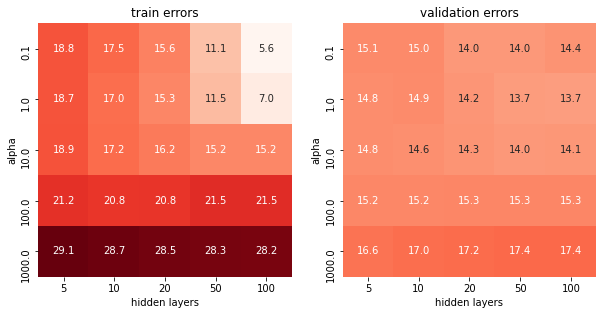

In [33]:
# Trực quan hóa kết quả
train_errs_df = pd.DataFrame(data=np.array(train_errs).reshape(len(alphas), -1),
                             index=alphas, columns=hidden_layers)
val_errs_df = pd.DataFrame(data=np.array(val_errs).reshape(len(alphas), -1), 
                           index=alphas, columns=hidden_layers)
min_err = min(min(train_errs), min(val_errs))
max_err = max(max(train_errs), max(val_errs))
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.heatmap(train_errs_df, vmin=min_err, vmax=max_err, square=True, annot=True, 
            cbar=False, fmt='.1f', cmap='Reds')
plt.title('train errors'); plt.xlabel('hidden layers'); plt.ylabel('alpha')
plt.subplot(1, 2, 2)
sns.heatmap(val_errs_df, vmin=min_err, vmax=max_err, square=True, annot=True, 
            cbar=False, fmt='.1f', cmap='Reds')
plt.title('validation errors'); plt.xlabel('hidden layers'); plt.ylabel('alpha');

Neural chạy khá lâu (khoảng 15p) !!!  
Bên train_errors, ta có thể thấy độ lỗi của mô hình dựa vào hidden layers , hidden layers càng cao thì càng fit mô hình
Dựa vào heatmap bên trên, mặc dù validation errors (hidden_layers = 100, alpha = 1.0) có độ lỗi nhỏ nhất nhưng khi nhìn qua ta có thể thấy bên train errors thì quá fit so với mô hình,tương tự với alpha = 0.1 thì ta cũng có thể thấy bị overfitting thay vào đó ta sẽ chọn hidden_layers = 50 , alpha = 1.0 làm tham số để chạy với bộ dữ liệu test 

In [34]:
# UnderSampling cả tập train và tập validation để đánh giá tập test
MLP_Tr_X,MLP_Tr_y = Tr_X_df, Tr_y_sr
undersample = RandomUnderSampler(sampling_strategy='majority')
MLP_Tr_X,MLP_Tr_y = undersample.fit_resample(MLP_Tr_X,MLP_Tr_y)

In [35]:
# Đánh giá độ chính xác của mô hình Neural Net trên tập test
full_pipeline.set_params(mlpclassifier__alpha=1,mlpclassifier__hidden_layer_sizes = (50))
full_pipeline.fit(MLP_Tr_X,MLP_Tr_y)
predict = full_pipeline.predict(test_X_df)
print('Độ chính xác của mô hình Neural Net:',accuracy_score(predict, test_y_sr)*100)

Độ chính xác của mô hình Neural Net: 86.8555438964673


#### Mô hình AdaBoost Classifier

Ta sẽ sử dụng mô hình AdaBoost Classifier để phân lớp. Bạn sẽ tạo ra một pipeline từ đầu đến cuối bao gồm: các bước tiền xử lý ở trên + AdaBoost Classifier

Sau khi đã có được pipeline từ đầu đến cuối này, ta sẽ thử nghiệm:
- Siêu tham số `n_estimators`của `AdaBoostClassifier` với 5 giá trị khác nhau: 10,20,50,100,150

In [36]:
#Tạo full pipeline  
full_pipeline = make_pipeline(ColAddDropper(),MissingValues(Numerical,Categorical),Standardized(),AdaBoostClassifier())
estimators_l = []
# Thử nghiệm với các giá trị khác nhau của siêu tham số n_estimators
# và chọn ra các giá trị tốt nhất
train_errs = []
val_errs = []
algorithm = ['SAMME.R']
estis = [10, 20, 50, 100, 150]
best_val_err = float('inf')
best_esti = None

for esti in estis:
    estimators_l.append(esti)
    full_pipeline.set_params(adaboostclassifier__n_estimators=esti)
    full_pipeline.fit(train_X_df,train_y_sr)
    train_errs.append((1-full_pipeline.score(train_X_df,train_y_sr))*100)
    val_errs.append((1-full_pipeline.score(val_X_df,val_y_sr))*100)
best_val_err = min(val_errs)
best_esti = estimators_l[val_errs.index(best_val_err)]
print('Độ lỗi tốt nhất trên tập validation: ',best_val_err)

Độ lỗi tốt nhất trên tập validation:  14.643814853678439


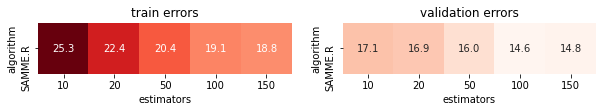

In [37]:
# Trực quan hóa kết quả
train_errs_df = pd.DataFrame(data=np.array(train_errs).reshape(len(algorithm), -1),
                             index=algorithm, columns=estis)
val_errs_df = pd.DataFrame(data=np.array(val_errs).reshape(len(algorithm), -1), 
                           index=algorithm, columns=estis)
min_err = min(min(train_errs), min(val_errs))
max_err = max(max(train_errs), max(val_errs))
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.heatmap(train_errs_df, vmin=min_err, vmax=max_err, square=True, annot=True, 
            cbar=False, fmt='.1f', cmap='Reds')
plt.title('train errors'); plt.xlabel('estimators'); plt.ylabel('algorithm')
plt.subplot(1, 2, 2)
sns.heatmap(val_errs_df, vmin=min_err, vmax=max_err, square=True, annot=True, 
            cbar=False, fmt='.1f', cmap='Reds')
plt.title('validation errors'); plt.xlabel('estimators'); plt.ylabel('algorithm');

Ở mô hình này ta có thể thấy, độ lỗi của mô hình giảm khi ta tăng chỉ số estimators (cả train errors và validation errors) Lý do validation errors thấp hơn so với train errors có thể do 1 phần lớn ảnh hưởng bởi việc undersampling tập train còn tập validation thì không  
Thì em hiểu đây là một thuật toán học tăng cường, n estimators chính là số lượng 'học viên' đạt trọng số thấp cần phải đào tạo lại có thể kết hợp với nhiều bộ phân loại (với tham số base_estimator=None, mặc đinh là DecisionTreeClassifier)

In [38]:
# UnderSampling cả tập train và tập validation để đánh giá tập test
Ada_Tr_X,Ada_Tr_y = Tr_X_df, Tr_y_sr
undersample = RandomUnderSampler(sampling_strategy='majority')
Ada_Tr_X,Ada_Tr_y = undersample.fit_resample(Ada_Tr_X,Ada_Tr_y)

In [39]:
# Đánh giá chính xác của mô hình AdaBoost Classifier trên tập test
full_pipeline.set_params(adaboostclassifier__n_estimators=best_esti)
full_pipeline.fit(Ada_Tr_X,Ada_Tr_y)
predict = full_pipeline.predict(test_X_df)
print("Độ chính xác của mô hình AdaBoost Classifier: ",accuracy_score(predict, test_y_sr)*100)

Độ chính xác của mô hình AdaBoost Classifier:  84.17628541448059


#### Mô hình Decision Tree Classifier

Ta sẽ thử mô hình Decision Tree Classifier với các tham số mặc định

In [40]:
full_pipeline = make_pipeline(ColAddDropper(),MissingValues(Numerical,Categorical),Standardized(),DecisionTreeClassifier())
full_pipeline.fit(train_X_df,train_y_sr)
print("Độ lỗi trên tập train:",(1-full_pipeline.score(train_X_df,train_y_sr))*100)
print("Độ lỗi trên tập validation:",(1-full_pipeline.score(val_X_df,val_y_sr))*100)

Độ lỗi trên tập train: 0.0
Độ lỗi trên tập validation: 14.066689984843183


Theo như quan sát độ lỗi của 2 tập (train và validation) thì với mô hình Decision Tree Classifier bị overfitting

In [41]:
# UnderSampling cả tập train và tập validation để đánh giá tập test
Dec_Tr_X,Dec_Tr_y = Tr_X_df, Tr_y_sr
undersample = RandomUnderSampler(sampling_strategy='majority')
Dec_Tr_X,Dec_Tr_y = undersample.fit_resample(Dec_Tr_X,Dec_Tr_y)

In [42]:
# Đánh giá độ chính xác của mô hình Decision Tree trên tập test
full_pipeline.fit(Dec_Tr_X,Dec_Tr_y)
predict = full_pipeline.predict(test_X_df)
print("Độ chính xác của mô hình Decision Tree: ",accuracy_score(predict, test_y_sr)*100)

Độ chính xác của mô hình Decision Tree:  87.02343476740118


#### Mô hình Logistic Regression

Ngoài ra ta sẽ thử thêm 1 mô hình nữa đó là Logistic Regression với tham số mặc định

In [43]:
full_pipeline = make_pipeline(ColAddDropper(),MissingValues(Numerical,Categorical),Standardized(),LogisticRegression())
full_pipeline.fit(train_X_df,train_y_sr)
print("Độ lỗi trên tập train:",(1-full_pipeline.score(train_X_df,train_y_sr))*100)
print("Độ lỗi trên tập validation:",(1-full_pipeline.score(val_X_df,val_y_sr))*100)

Độ lỗi trên tập train: 22.98728813559322
Độ lỗi trên tập validation: 15.337530605106686


Độ lỗi của tập train nhỏ hơn độ lỗi của tập validation, theo như em nghĩ ở trên thì có vẻ là do undersampling bộ train và giữ nguyên bộ validation

In [44]:
# UnderSampling cả tập train và tập validation để đánh giá tập test
Log_Tr_X,Log_Tr_y = Tr_X_df, Tr_y_sr
undersample = RandomUnderSampler(sampling_strategy='majority')
Log_Tr_X,Log_Tr_y = undersample.fit_resample(Log_Tr_X,Log_Tr_y)

In [45]:
# Đánh giá độ chính xác của mô hình Logistic Regression trên tập test
full_pipeline.fit(Log_Tr_X,Log_Tr_y)
predict = full_pipeline.predict(test_X_df)
print("Độ chính xác của mô hình Logistic Regression: ",accuracy_score(predict, test_y_sr)*100)

Độ chính xác của mô hình Logistic Regression:  84.59601259181532


## Nhìn lại quá trình làm đồ án

**Khó khăn:**  
+ Lúc tìm dữ liệu thời tiết, tuy nhiều trang API cung cấp dữ liệu về thời tiết nhưng có giới hạn về số lượng dữ liệu được lấy (thời gian) , lấy trang metaweather nhưng có vẻ dữ liệu thời tiết của nó không được đúng cho lắm :v
+ Trong quá trình làm, nhóm em có khó khăn trong vấn đề bị imblanced dataset. (Nhomse m đã thử làm mà không cần under/oversampling dữ liệu mà chỉ điều chỉnh trọng số lớp trong thuật toán, tuy nhiên theo các bạn đóng góp cho đồ án của nhóm em và em cũng suy nghĩ mình cũng nên thử với việc undersampling dữ liệu coi có sự thay đổi gì không) 
+ Tuy có cảm hứng làm với thời tiết nhưng nhóm em lại muốn làm gì đó nó mới mẻ hơn , có thử nghĩ qua một vài chủ đề khác nhưng cái cảm hứng của nhóm em nó lấn át rồi ạ :))    

**Những điều học được:**    
+ Biết thêm nhiều về Git , Github  
+ Biết thêm về file markdown
+ Tăng khả năng làm việc nhóm  
+ Biết được thêm nhiều mô hình dữ liệu hơn    
+ Biết được thêm quá trình xử lý nếu dữ liệu bị mất cân bằng
+ Suy ngẫm về nhiều điều trong thực tế có thể mô hình hóa hay không ? (Tự đặt câu hỏi, thấy nhiều bài toán khá thú vị ) 

Ngoài ra còn được học hỏi được nhiều từ góp ý của các bạn nhóm khác,nhóm em thấy thầy làm thêm cái góp ý (issue) trong đồ án này khá hay

**Nếu có thêm thời gian thì bọn em sẽ dành thời gian nhiều hơn cho việc suy nghĩ ý tưởng hơn và thử qua nhiều mô hình hơn**

## Nguồn tham khảo

- [Metaweather](www.metaweather.com)      
- [Sklearn](scikit-learn.org)  
- [Imblearn](imbalanced-learn.org)
- [Imblanced Dataset 1](https://datascience.stackexchange.com/questions/61858/oversampling-undersampling-only-train-set-only-or-both-train-and-validation-set)
- [Imblanced Dataset 2](https://datascience.stackexchange.com/questions/8895/with-unbalanced-class-do-i-have-to-use-under-sampling-on-my-validation-testing)
- File tài liệu bài tập  